Import

In [1]:
from huggingface_hub import notebook_login
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from torch import nn
from transformers import TrainingArguments
from transformers import Trainer
import os,glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
var_range_9 = np.arange(9)
model_checkpoint = "distilbert-base-cased"

Login Notebook

In [ ]:
notebook_login()

Processing the data

In [5]:
raw_datasets = load_dataset("conll2003")

ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Found cached dataset conll2003 (C:/Users/ADMIN/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\ADMIN\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ADMIN\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Loading cached processed dataset at C:\Users\ADMIN\.cache\huggingface\datasets\datnth1709___parquet\datnth1709--VLSP2016-NER-data-d43af4e5718e456d\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-696cec0374fd8e9c.arrow


Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Data augmentation

In [ ]:
import nlpaug.augmenter.word as naw
augmenter = naw.SynonymAug(aug_src='wordnet')

def get_aug_tokens(examples):
    result = []
    for tokens, ner_tags in zip(examples['tokens'], examples['ner_tags']):
        aug_tokens = []
        for token, ner_tag in zip(tokens, ner_tags):
            if ner_tag == 0:
                augmented_token = augmenter.augment(token)
                aug_tokens.append(augmented_token[0])
            else:
                aug_tokens.append(token)
        result.append(aug_tokens)
    return result

# augmenter_tokens = [augmenter.augment(token) for token in raw_datasets["train"]["tokens"]]

def custom_dataset(examples):
    tokenized_inputs = tokenizer(
        get_aug_tokens(examples), truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

cus_tokenized_datasets = raw_datasets.map(
    custom_dataset,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

In [6]:
from datasets import DatasetDict, concatenate_datasets
concatenated_dataset_dict = DatasetDict({
    "train": concatenate_datasets([cus_tokenized_datasets["train"], tokenized_datasets["train"]]),
    "validation": concatenate_datasets([cus_tokenized_datasets["validation"], tokenized_datasets["validation"]]),
    "test": concatenate_datasets([cus_tokenized_datasets["test"], tokenized_datasets["test"]])
})

concatenated_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28082
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6906
    })
})

Data collation & Defining the model

In [6]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [6]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [1]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

dropout_rate = 0.1
# model.bert.encoder.layer[-1].output.dropout = nn.Dropout(dropout_rate)
# model.distilbert.transformer.layer[-1].output_dropout = nn.Dropout(dropout_rate)

for layer in model.distilbert.transformer.layer:
    layer.output_dropout = nn.Dropout(0.1)

epoch = 10
args = TrainingArguments(
    "distilbert-base-multilingual-vn",
    overwrite_output_dir=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    learning_rate=2e-5,
    num_train_epochs=epoch,
    weight_decay=0.01,
    push_to_hub=False,
)


NameError: name 'AutoModelForTokenClassification' is not defined

Fine-tuning the model

In [ ]:

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train()
# trainer.push_to_hub(commit_message="Training complete")
trainer.save_model()

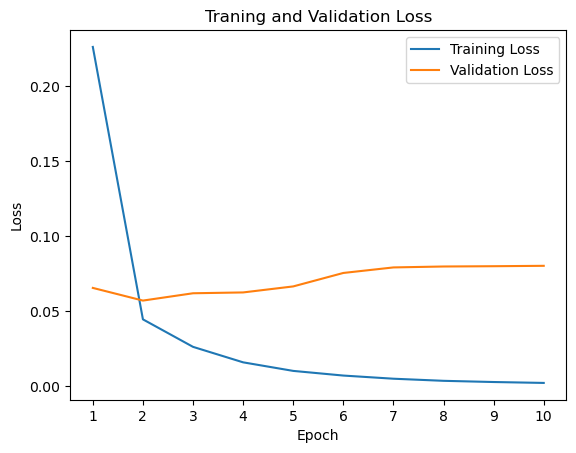

In [12]:
log_history = trainer.state.log_history
index = 0
validation_loss_values = []
training_loss_values = []
for entry in log_history:
  if 'eval_loss' in entry:
    index += 1
    validation_loss_values.append(entry['eval_loss'])

  if 'loss' in entry:
    if(len(training_loss_values) -1 == index):
      training_loss_values[index] = entry['loss']
    else:
      training_loss_values.append(entry['loss'])


# Lấy thông tin về loss từ trainer.state.log_history
eval_loss_values = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]


loss_values = [entry['loss'] for entry in log_history if 'loss' in entry]
epochs = range(1,index + 1)
# Vẽ biểu đồ loss

plt.plot(epochs , training_loss_values, label='Training Loss')
plt.plot(epochs , validation_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Traning and Validation Loss')

# Set the tick locations
plt.xticks(range(11)[1:])
plt.legend(loc='best')
plt.show()



Load the model in Dir

In [3]:
checkpoints = glob.glob(os.path.join("distilbert-base", "checkpoint-*"))
sorted_checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[2]))
print(sorted_checkpoints)

['distilbert-base\\checkpoint-878', 'distilbert-base\\checkpoint-1756', 'distilbert-base\\checkpoint-2634', 'distilbert-base\\checkpoint-3512', 'distilbert-base\\checkpoint-4390', 'distilbert-base\\checkpoint-5268', 'distilbert-base\\checkpoint-6146', 'distilbert-base\\checkpoint-7024', 'distilbert-base\\checkpoint-7902', 'distilbert-base\\checkpoint-8780']


In [ ]:
checkpoint = sorted_checkpoints[7]
print( checkpoint)

model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)
trainer.model = model
# trainer.push_to_hub(commit_message="Training complete")

Predict

In [15]:
outputs = trainer.predict(tokenized_datasets["test"])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/216 [00:00<?, ?it/s]

In [16]:
actual_labels = outputs.label_ids
predicted_labels = np.argmax(outputs.predictions, axis=2)

In [17]:

lines = []
tokens = []

def calculate_confusion_matrix(actual_labels, predicted_labels):
    confusion_matrix = np.zeros((9, 9), dtype=int)
    for index_x, (actual, predicted) in enumerate(zip(actual_labels, predicted_labels)):
        for index_y, (a, p) in enumerate(zip(actual, predicted)):
            if a >= 0:
                confusion_matrix[a,p] += 1
                if(a==8 and p==0):
                    tokens.append(tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][index_x][index_y]))
                    lines.append([str(index_x)])
                    lines.append(raw_datasets["test"]["tokens"][index_x])
                    lines.append(tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][index_x]))
                    lines.append(tokenizer.convert_ids_to_tokens(tokenized_datasets["test"]["input_ids"][index_x][index_y]))
    return confusion_matrix

confusion_matrix = calculate_confusion_matrix(actual_labels, predicted_labels)

accuracy: 0.95


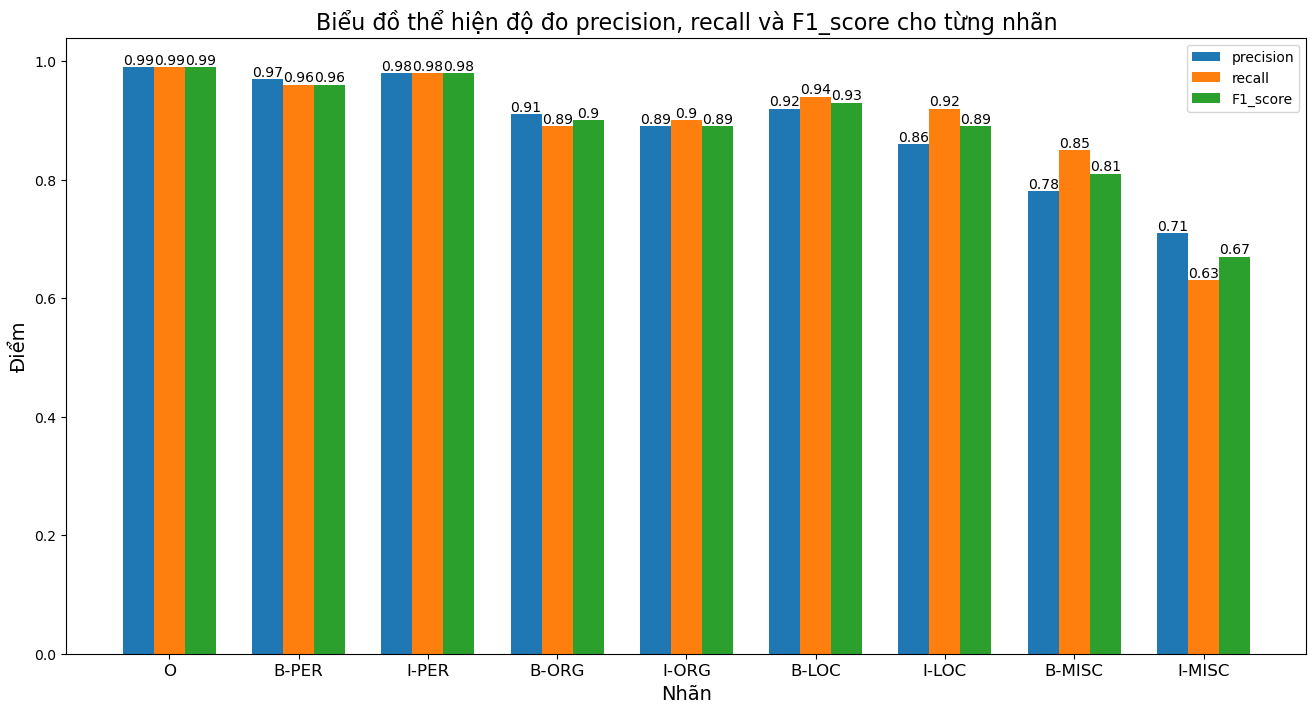

In [18]:
TP = [confusion_matrix[i,i] for i in var_range_9]
MX_sum = confusion_matrix.sum()
FP = [sum(confusion_matrix[:, i]) - TP[i] for i in var_range_9]
FN = [sum(confusion_matrix[i, :]) - TP[i] for i in var_range_9]
TN = [MX_sum - (TP[i] + FP[i] + FN[i]) for i in var_range_9]

accuracy = sum(TP[1:]) / confusion_matrix[1:, 1:].sum()
print("accuracy: {:.2f}".format(accuracy))

precision = [round(TP[i] / (TP[i] + FP[i]),2) for i in var_range_9]
recall = [round(TP[i] / (TP[i] + FN[i]),2) for i in var_range_9]
F1_score = [round(2 * (precision[i] * recall[i])/ (precision[i] + recall[i]),2)  for i in var_range_9]

width = 0.24
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xticks(var_range_9 + width)
ax.set_xticklabels(label_names, fontsize=12)
plt.xlabel('Nhãn', fontsize=14)
plt.ylabel('Điểm', fontsize=14)
plt.title('Biểu đồ thể hiện độ đo precision, recall và F1_score cho từng nhãn', fontsize=16)
colors_list = ['Red','Orange', 'Blue', 'Purple']
penguin_means = {
    "precision" : precision,
    "recall" : recall,
    "F1_score" :F1_score
}
multiplier = 0
for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(var_range_9 + offset, measurement, width, label=attribute)
    ax.bar_label(rects,fontsize=10)
    multiplier += 1
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')
plt.show()

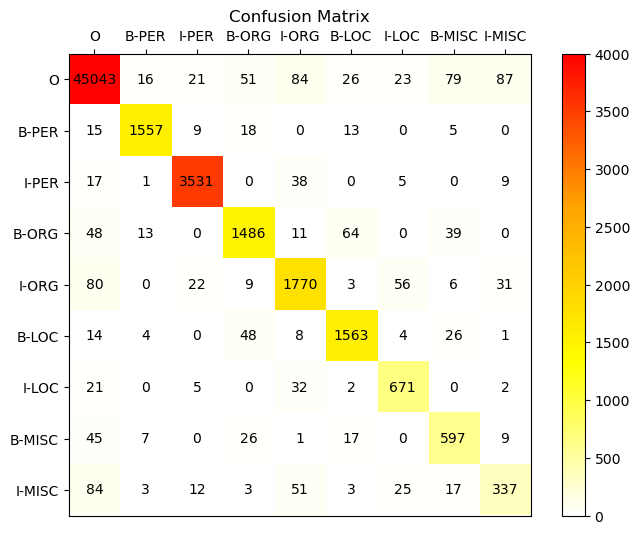

In [19]:
import matplotlib.colors as mcolors
colors = ['white', 'yellow', 'orange', 'red']
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=256)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_matrix, cmap=cmap_custom,vmax=4000)
ax.set_title("Confusion Matrix")
ax.set_xticks(var_range_9)
ax.set_yticks(var_range_9)
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
for i in var_range_9:
    for j in var_range_9:
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')
plt.colorbar(im)
ax.xaxis.tick_top()
plt.show()

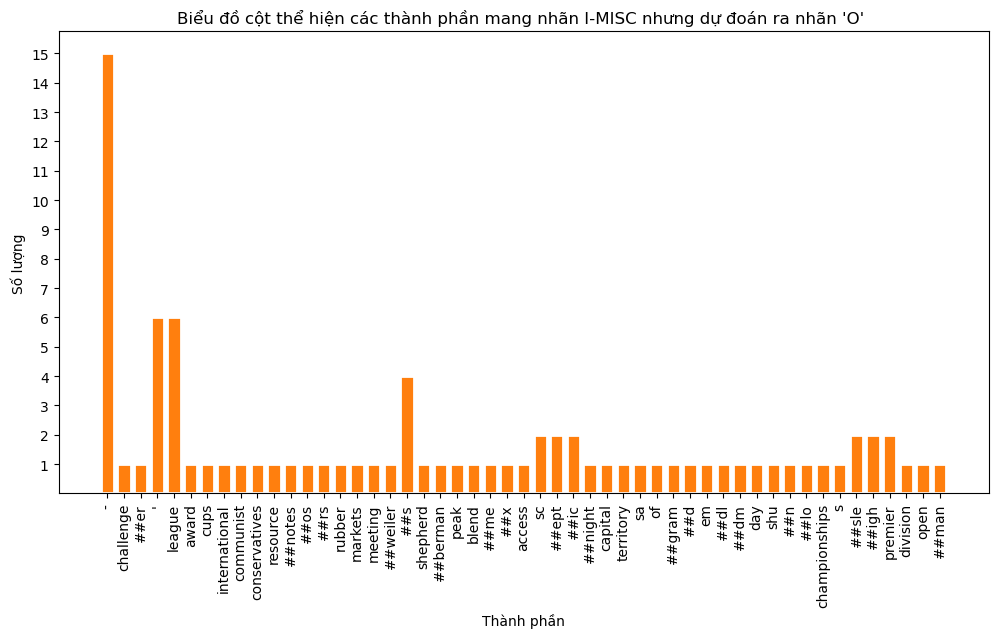

In [20]:
from collections import Counter
frequencies = Counter(tokens)

# Chuyển đổi kết quả Counter thành các list keys và values
keys = list(frequencies.keys())
values = list(frequencies.values())

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
plt.bar(keys, values,width=0.5)
plt.xlabel('Thành phần')
plt.ylabel('Số lượng')
plt.title("Biểu đồ cột thể hiện các thành phần mang nhãn I-MISC nhưng dự đoán ra nhãn 'O' ")
plt.yticks(range(int(min(values)), int(max(values))+1))
plt.xticks(np.arange(len(keys)), rotation='vertical')
plt.bar(keys, values, width=0.8, edgecolor='white', linewidth=2)
plt.show()

In [21]:
file_path = "du_lieu.txt"
lines_str = "\n".join(' '.join(item) if isinstance(item, list) else item for item in lines)
with open(file_path, 'w') as file:
    file.writelines(lines_str)

In [22]:
vocab = tokenizer.get_vocab()
char_id = vocab["-"]

In [23]:
def find_char():
    label_counts = [0,0,0,0,0,0,0,0,0]
    for example in tokenized_datasets["train"]:
        input_ids = example['input_ids']
        labels = example['labels']
        for id,label in zip(input_ids,labels):
            
            if char_id == id:
                # print(token)
                # if ner_tag not in label_counts:
                #     label_counts[ner_tag] = 1
                # else:
                label_counts[label] += 1
    return label_counts

In [24]:
data = find_char()
print(data)

[8078, 0, 109, 0, 69, 0, 42, 0, 200]


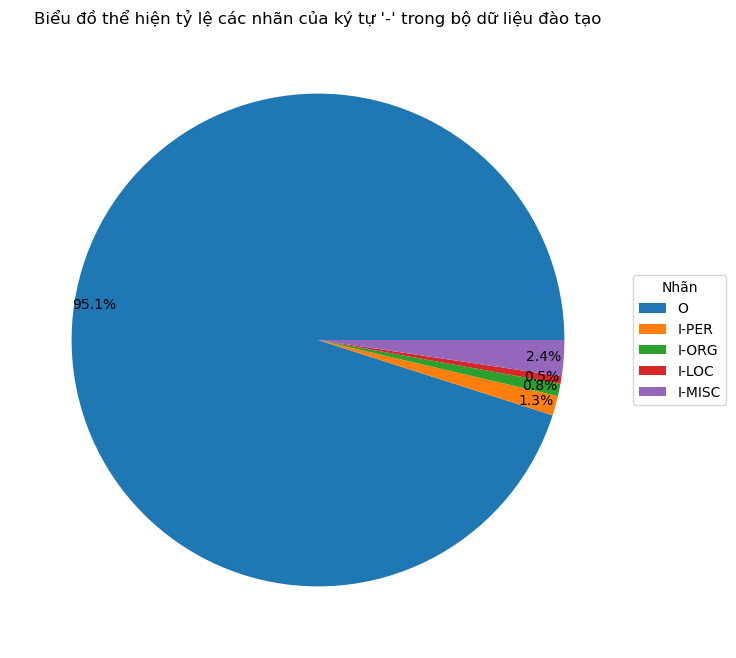

In [25]:
non_zero_labels = []
non_zero_data = []
for i in var_range_9:
    if data[i] != 0:
        non_zero_labels.append(label_names[i])
        non_zero_data.append(data[i])
plt.figure(figsize=(8, 8)) 
plt.pie(non_zero_data, labels=[""] * len(non_zero_labels), autopct='%1.1f%%',pctdistance=0.92)
plt.title("Biểu đồ thể hiện tỷ lệ các nhãn của ký tự '-' trong bộ dữ liệu đào tạo")
plt.legend(non_zero_labels, title="Nhãn", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()